In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./circuit'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [31]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [32]:
data_dir='./datanew'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform = transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)])
train_ds = ImageFolder(data_dir, transform)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [33]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [35]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

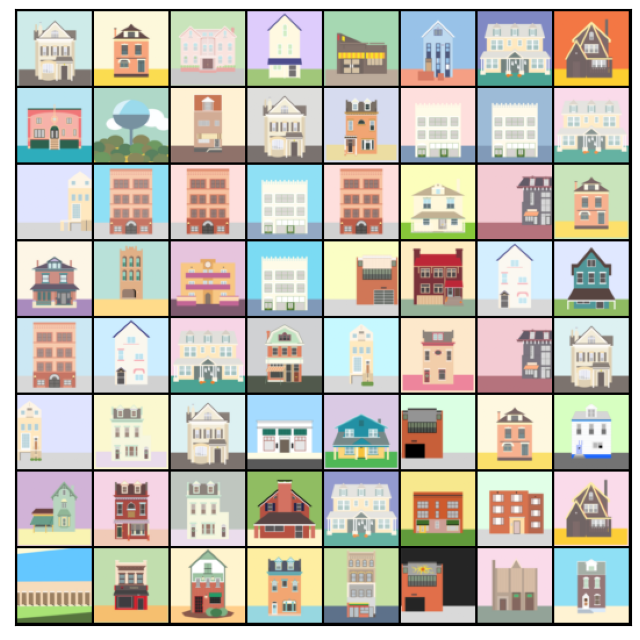

In [36]:
show_batch(train_dl)

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [38]:
device = get_default_device()
device

device(type='cuda')

In [39]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
train_dl = DeviceDataLoader(train_dl, device)

In [41]:
import torch.nn as nn

In [42]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid())

In [43]:
discriminator = to_device(discriminator, device)

In [44]:
latent_size = 128

In [45]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


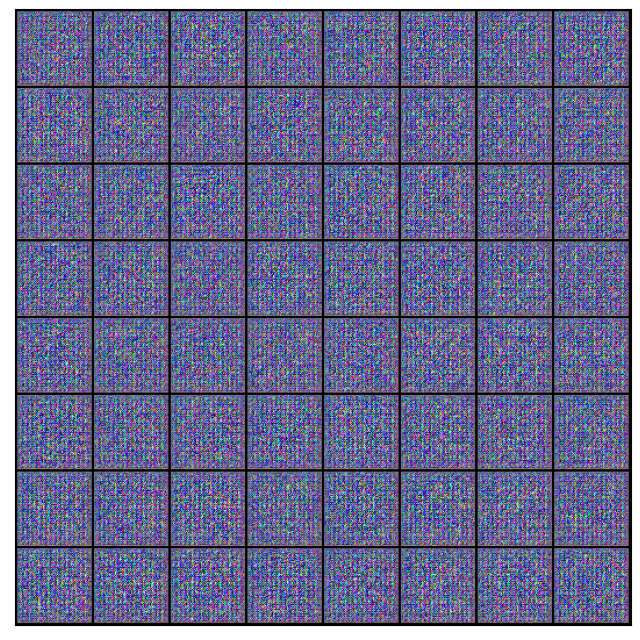

In [46]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [47]:
generator = to_device(generator, device)

In [48]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [49]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [50]:
from torchvision.utils import save_image

In [51]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [52]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [53]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


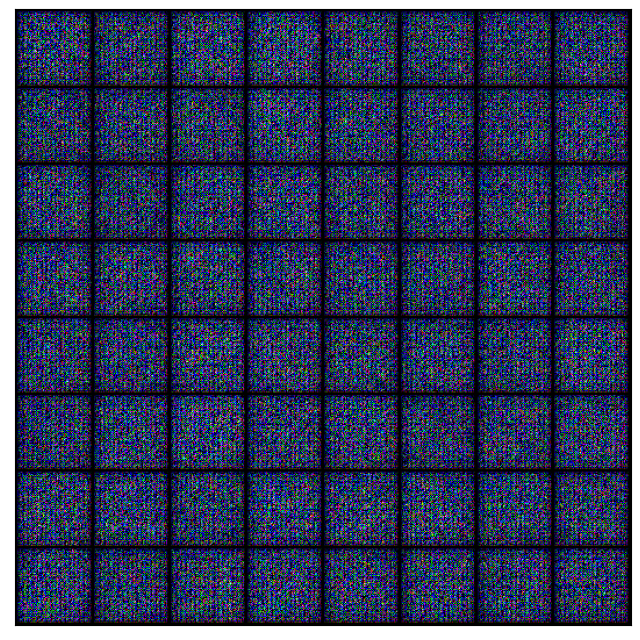

In [54]:
save_samples(0, fixed_latent)

In [55]:
from tqdm import tqdm
import torch.nn.functional as F

In [56]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [57]:
lr = 0.0002
epochs = 250

In [58]:
history = fit(epochs, lr)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.31it/s]


Epoch [1/250], loss_g: 16.7385, loss_d: 0.0026, real_score: 0.9974, fake_score: 0.0000
Saving generated-images-0001.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [2/250], loss_g: 5.8234, loss_d: 0.0528, real_score: 0.9971, fake_score: 0.0477
Saving generated-images-0002.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [3/250], loss_g: 7.5140, loss_d: 0.5786, real_score: 0.9314, fake_score: 0.3837
Saving generated-images-0003.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.59it/s]


Epoch [4/250], loss_g: 7.1293, loss_d: 0.3644, real_score: 0.9355, fake_score: 0.2434
Saving generated-images-0004.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [5/250], loss_g: 6.8457, loss_d: 0.2814, real_score: 0.9451, fake_score: 0.1915
Saving generated-images-0005.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [6/250], loss_g: 3.2887, loss_d: 0.0963, real_score: 0.9915, fake_score: 0.0760
Saving generated-images-0006.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [7/250], loss_g: 5.9864, loss_d: 0.1874, real_score: 0.9739, fake_score: 0.1431
Saving generated-images-0007.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [8/250], loss_g: 5.7736, loss_d: 0.0754, real_score: 0.9569, fake_score: 0.0264
Saving generated-images-0008.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [9/250], loss_g: 6.5810, loss_d: 0.0182, real_score: 0.9892, fake_score: 0.0072
Saving generated-images-0009.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [10/250], loss_g: 6.5179, loss_d: 0.0113, real_score: 0.9941, fake_score: 0.0054
Saving generated-images-0010.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.53it/s]


Epoch [11/250], loss_g: 6.8972, loss_d: 0.0042, real_score: 0.9981, fake_score: 0.0022
Saving generated-images-0011.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.47it/s]


Epoch [12/250], loss_g: 7.3471, loss_d: 0.0023, real_score: 0.9991, fake_score: 0.0014
Saving generated-images-0012.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.60it/s]


Epoch [13/250], loss_g: 5.7277, loss_d: 0.0041, real_score: 0.9991, fake_score: 0.0033
Saving generated-images-0013.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.63it/s]


Epoch [14/250], loss_g: 4.2061, loss_d: 0.1330, real_score: 0.9408, fake_score: 0.0632
Saving generated-images-0014.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [15/250], loss_g: 6.3251, loss_d: 0.0443, real_score: 0.9866, fake_score: 0.0301
Saving generated-images-0015.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.78it/s]


Epoch [16/250], loss_g: 6.4200, loss_d: 0.0385, real_score: 0.9871, fake_score: 0.0250
Saving generated-images-0016.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.60it/s]


Epoch [17/250], loss_g: 5.7238, loss_d: 0.1951, real_score: 0.9248, fake_score: 0.0806
Saving generated-images-0017.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.76it/s]


Epoch [18/250], loss_g: 5.9868, loss_d: 0.3389, real_score: 0.9436, fake_score: 0.2248
Saving generated-images-0018.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.80it/s]


Epoch [19/250], loss_g: 6.6902, loss_d: 0.1023, real_score: 0.9164, fake_score: 0.0036
Saving generated-images-0019.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.56it/s]


Epoch [20/250], loss_g: 6.8943, loss_d: 0.0365, real_score: 0.9800, fake_score: 0.0158
Saving generated-images-0020.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.86it/s]


Epoch [21/250], loss_g: 5.3721, loss_d: 0.0677, real_score: 0.9906, fake_score: 0.0421
Saving generated-images-0021.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.49it/s]


Epoch [22/250], loss_g: 2.7044, loss_d: 0.1542, real_score: 0.8931, fake_score: 0.0242
Saving generated-images-0022.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.79it/s]


Epoch [23/250], loss_g: 8.3382, loss_d: 0.2502, real_score: 0.9847, fake_score: 0.1998
Saving generated-images-0023.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.79it/s]


Epoch [24/250], loss_g: 6.2600, loss_d: 0.0650, real_score: 0.9855, fake_score: 0.0476
Saving generated-images-0024.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.48it/s]


Epoch [25/250], loss_g: 7.9845, loss_d: 0.2902, real_score: 0.9715, fake_score: 0.2076
Saving generated-images-0025.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.57it/s]


Epoch [26/250], loss_g: 7.2497, loss_d: 0.1393, real_score: 0.9851, fake_score: 0.1141
Saving generated-images-0026.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [27/250], loss_g: 5.8520, loss_d: 0.2338, real_score: 0.8966, fake_score: 0.1036
Saving generated-images-0027.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.93it/s]


Epoch [28/250], loss_g: 3.5843, loss_d: 0.1488, real_score: 0.8991, fake_score: 0.0386
Saving generated-images-0028.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [29/250], loss_g: 5.1988, loss_d: 0.0293, real_score: 0.9960, fake_score: 0.0248
Saving generated-images-0029.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [30/250], loss_g: 0.6749, loss_d: 0.1686, real_score: 0.8743, fake_score: 0.0279
Saving generated-images-0030.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [31/250], loss_g: 4.4665, loss_d: 0.1016, real_score: 0.9475, fake_score: 0.0453
Saving generated-images-0031.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [32/250], loss_g: 5.0598, loss_d: 0.0576, real_score: 0.9852, fake_score: 0.0411
Saving generated-images-0032.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.79it/s]


Epoch [33/250], loss_g: 5.1218, loss_d: 0.0570, real_score: 0.9751, fake_score: 0.0306
Saving generated-images-0033.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.48it/s]


Epoch [34/250], loss_g: 5.1857, loss_d: 0.0717, real_score: 0.9813, fake_score: 0.0507
Saving generated-images-0034.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.86it/s]


Epoch [35/250], loss_g: 4.0182, loss_d: 0.1229, real_score: 0.9082, fake_score: 0.0226
Saving generated-images-0035.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.90it/s]


Epoch [36/250], loss_g: 4.9909, loss_d: 0.0486, real_score: 0.9729, fake_score: 0.0204
Saving generated-images-0036.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [37/250], loss_g: 5.2425, loss_d: 0.0343, real_score: 0.9855, fake_score: 0.0193
Saving generated-images-0037.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [38/250], loss_g: 5.3008, loss_d: 0.0218, real_score: 0.9888, fake_score: 0.0104
Saving generated-images-0038.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.92it/s]


Epoch [39/250], loss_g: 5.4705, loss_d: 0.0178, real_score: 0.9927, fake_score: 0.0102
Saving generated-images-0039.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.93it/s]


Epoch [40/250], loss_g: 5.3615, loss_d: 0.0193, real_score: 0.9915, fake_score: 0.0107
Saving generated-images-0040.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.91it/s]


Epoch [41/250], loss_g: 5.3610, loss_d: 0.0160, real_score: 0.9897, fake_score: 0.0056
Saving generated-images-0041.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [42/250], loss_g: 4.8813, loss_d: 0.0164, real_score: 0.9937, fake_score: 0.0099
Saving generated-images-0042.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [43/250], loss_g: 6.5071, loss_d: 0.0119, real_score: 0.9958, fake_score: 0.0076
Saving generated-images-0043.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [44/250], loss_g: 6.0486, loss_d: 0.1903, real_score: 0.9474, fake_score: 0.1202
Saving generated-images-0044.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [45/250], loss_g: 4.9054, loss_d: 0.0705, real_score: 0.9596, fake_score: 0.0277
Saving generated-images-0045.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [46/250], loss_g: 4.8167, loss_d: 0.0325, real_score: 0.9874, fake_score: 0.0195
Saving generated-images-0046.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [47/250], loss_g: 5.5544, loss_d: 0.0252, real_score: 0.9943, fake_score: 0.0191
Saving generated-images-0047.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [48/250], loss_g: 4.3787, loss_d: 0.0415, real_score: 0.9688, fake_score: 0.0089
Saving generated-images-0048.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [49/250], loss_g: 7.2128, loss_d: 0.0731, real_score: 0.9863, fake_score: 0.0559
Saving generated-images-0049.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [50/250], loss_g: 5.4100, loss_d: 0.0313, real_score: 0.9832, fake_score: 0.0140
Saving generated-images-0050.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.89it/s]


Epoch [51/250], loss_g: 5.3824, loss_d: 0.0235, real_score: 0.9907, fake_score: 0.0138
Saving generated-images-0051.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [52/250], loss_g: 5.6331, loss_d: 0.0157, real_score: 0.9921, fake_score: 0.0076
Saving generated-images-0052.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [53/250], loss_g: 5.4916, loss_d: 0.0209, real_score: 0.9897, fake_score: 0.0104
Saving generated-images-0053.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [54/250], loss_g: 5.3740, loss_d: 0.0130, real_score: 0.9943, fake_score: 0.0072
Saving generated-images-0054.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.86it/s]


Epoch [55/250], loss_g: 6.6506, loss_d: 0.0084, real_score: 0.9949, fake_score: 0.0032
Saving generated-images-0055.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [56/250], loss_g: 5.8288, loss_d: 0.0089, real_score: 0.9954, fake_score: 0.0043
Saving generated-images-0056.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.80it/s]


Epoch [57/250], loss_g: 5.8429, loss_d: 0.0141, real_score: 0.9897, fake_score: 0.0037
Saving generated-images-0057.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [58/250], loss_g: 6.3423, loss_d: 0.0105, real_score: 0.9931, fake_score: 0.0035
Saving generated-images-0058.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.91it/s]


Epoch [59/250], loss_g: 7.2246, loss_d: 0.0048, real_score: 0.9987, fake_score: 0.0035
Saving generated-images-0059.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.75it/s]


Epoch [60/250], loss_g: 5.9037, loss_d: 0.0087, real_score: 0.9946, fake_score: 0.0033
Saving generated-images-0060.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.93it/s]


Epoch [61/250], loss_g: 6.8205, loss_d: 0.2498, real_score: 0.8558, fake_score: 0.0258
Saving generated-images-0061.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [62/250], loss_g: 8.1902, loss_d: 0.0882, real_score: 0.9780, fake_score: 0.0609
Saving generated-images-0062.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.92it/s]


Epoch [63/250], loss_g: 6.3586, loss_d: 0.0290, real_score: 0.9841, fake_score: 0.0127
Saving generated-images-0063.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [64/250], loss_g: 4.7574, loss_d: 0.0430, real_score: 0.9708, fake_score: 0.0124
Saving generated-images-0064.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [65/250], loss_g: 6.0627, loss_d: 0.0117, real_score: 0.9946, fake_score: 0.0063
Saving generated-images-0065.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.91it/s]


Epoch [66/250], loss_g: 4.6104, loss_d: 0.0244, real_score: 0.9798, fake_score: 0.0038
Saving generated-images-0066.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.94it/s]


Epoch [67/250], loss_g: 4.6234, loss_d: 0.0275, real_score: 0.9823, fake_score: 0.0090
Saving generated-images-0067.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.91it/s]


Epoch [68/250], loss_g: 7.7624, loss_d: 0.3212, real_score: 0.8995, fake_score: 0.1294
Saving generated-images-0068.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [69/250], loss_g: 5.8596, loss_d: 0.0638, real_score: 0.9675, fake_score: 0.0292
Saving generated-images-0069.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [70/250], loss_g: 6.2297, loss_d: 0.0314, real_score: 0.9954, fake_score: 0.0263
Saving generated-images-0070.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [71/250], loss_g: 5.4454, loss_d: 0.0186, real_score: 0.9887, fake_score: 0.0071
Saving generated-images-0071.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [72/250], loss_g: 5.5460, loss_d: 0.0211, real_score: 0.9854, fake_score: 0.0063
Saving generated-images-0072.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [73/250], loss_g: 4.5773, loss_d: 0.0364, real_score: 0.9737, fake_score: 0.0093
Saving generated-images-0073.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [74/250], loss_g: 6.0045, loss_d: 0.0071, real_score: 0.9960, fake_score: 0.0031
Saving generated-images-0074.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [75/250], loss_g: 7.6393, loss_d: 0.0089, real_score: 0.9977, fake_score: 0.0065
Saving generated-images-0075.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [76/250], loss_g: 7.1283, loss_d: 0.0324, real_score: 0.9848, fake_score: 0.0166
Saving generated-images-0076.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.67it/s]


Epoch [77/250], loss_g: 6.2610, loss_d: 0.0506, real_score: 0.9829, fake_score: 0.0323
Saving generated-images-0077.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.49it/s]


Epoch [78/250], loss_g: 5.9332, loss_d: 0.0277, real_score: 0.9808, fake_score: 0.0080
Saving generated-images-0078.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.52it/s]


Epoch [79/250], loss_g: 5.9119, loss_d: 0.0150, real_score: 0.9930, fake_score: 0.0080
Saving generated-images-0079.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.49it/s]


Epoch [80/250], loss_g: 4.5906, loss_d: 0.0259, real_score: 0.9786, fake_score: 0.0041
Saving generated-images-0080.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.73it/s]


Epoch [81/250], loss_g: 6.4187, loss_d: 0.0101, real_score: 0.9940, fake_score: 0.0041
Saving generated-images-0081.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [82/250], loss_g: 6.5059, loss_d: 0.0091, real_score: 0.9945, fake_score: 0.0036
Saving generated-images-0082.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.80it/s]


Epoch [83/250], loss_g: 7.7755, loss_d: 0.0185, real_score: 0.9845, fake_score: 0.0027
Saving generated-images-0083.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [84/250], loss_g: 5.5701, loss_d: 0.0501, real_score: 0.9726, fake_score: 0.0215
Saving generated-images-0084.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [85/250], loss_g: 5.7682, loss_d: 0.0311, real_score: 0.9839, fake_score: 0.0145
Saving generated-images-0085.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.72it/s]


Epoch [86/250], loss_g: 4.4699, loss_d: 0.0366, real_score: 0.9733, fake_score: 0.0087
Saving generated-images-0086.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.73it/s]


Epoch [87/250], loss_g: 5.8044, loss_d: 0.0089, real_score: 0.9990, fake_score: 0.0079
Saving generated-images-0087.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.70it/s]


Epoch [88/250], loss_g: 5.1936, loss_d: 0.0173, real_score: 0.9860, fake_score: 0.0030
Saving generated-images-0088.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.67it/s]


Epoch [89/250], loss_g: 5.9010, loss_d: 0.0063, real_score: 0.9970, fake_score: 0.0033
Saving generated-images-0089.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.75it/s]


Epoch [90/250], loss_g: 6.2073, loss_d: 0.0151, real_score: 0.9881, fake_score: 0.0027
Saving generated-images-0090.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.55it/s]


Epoch [91/250], loss_g: 6.1447, loss_d: 0.0085, real_score: 0.9956, fake_score: 0.0040
Saving generated-images-0091.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.72it/s]


Epoch [92/250], loss_g: 5.8869, loss_d: 0.0111, real_score: 0.9921, fake_score: 0.0031
Saving generated-images-0092.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.75it/s]


Epoch [93/250], loss_g: 6.7538, loss_d: 0.0060, real_score: 0.9956, fake_score: 0.0016
Saving generated-images-0093.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [94/250], loss_g: 6.1537, loss_d: 0.0075, real_score: 0.9954, fake_score: 0.0028
Saving generated-images-0094.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [95/250], loss_g: 5.5815, loss_d: 0.0191, real_score: 0.9851, fake_score: 0.0038
Saving generated-images-0095.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [96/250], loss_g: 5.6434, loss_d: 0.0136, real_score: 0.9895, fake_score: 0.0029
Saving generated-images-0096.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [97/250], loss_g: 6.5747, loss_d: 0.1715, real_score: 0.9473, fake_score: 0.0935
Saving generated-images-0097.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [98/250], loss_g: 6.7184, loss_d: 0.0256, real_score: 0.9918, fake_score: 0.0170
Saving generated-images-0098.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.73it/s]


Epoch [99/250], loss_g: 6.1738, loss_d: 0.0271, real_score: 0.9834, fake_score: 0.0102
Saving generated-images-0099.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [100/250], loss_g: 7.2952, loss_d: 0.0168, real_score: 0.9866, fake_score: 0.0030
Saving generated-images-0100.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.73it/s]


Epoch [101/250], loss_g: 5.2681, loss_d: 0.0193, real_score: 0.9862, fake_score: 0.0051
Saving generated-images-0101.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [102/250], loss_g: 3.8659, loss_d: 0.0355, real_score: 0.9690, fake_score: 0.0030
Saving generated-images-0102.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.78it/s]


Epoch [103/250], loss_g: 6.2588, loss_d: 0.0175, real_score: 0.9866, fake_score: 0.0037
Saving generated-images-0103.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.77it/s]


Epoch [104/250], loss_g: 6.9280, loss_d: 0.0157, real_score: 0.9897, fake_score: 0.0052
Saving generated-images-0104.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.80it/s]


Epoch [105/250], loss_g: 6.7175, loss_d: 0.0063, real_score: 0.9963, fake_score: 0.0026
Saving generated-images-0105.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.76it/s]


Epoch [106/250], loss_g: 6.1999, loss_d: 0.0116, real_score: 0.9915, fake_score: 0.0027
Saving generated-images-0106.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.58it/s]


Epoch [107/250], loss_g: 7.1164, loss_d: 0.0105, real_score: 0.9935, fake_score: 0.0039
Saving generated-images-0107.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.48it/s]


Epoch [108/250], loss_g: 7.0750, loss_d: 0.0027, real_score: 0.9990, fake_score: 0.0017
Saving generated-images-0108.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.66it/s]


Epoch [109/250], loss_g: 6.3959, loss_d: 0.0048, real_score: 0.9985, fake_score: 0.0032
Saving generated-images-0109.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.68it/s]


Epoch [110/250], loss_g: 6.5574, loss_d: 0.0053, real_score: 0.9968, fake_score: 0.0021
Saving generated-images-0110.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [111/250], loss_g: 7.2260, loss_d: 0.0066, real_score: 0.9956, fake_score: 0.0021
Saving generated-images-0111.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.91it/s]


Epoch [112/250], loss_g: 7.2520, loss_d: 0.0025, real_score: 0.9995, fake_score: 0.0020
Saving generated-images-0112.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [113/250], loss_g: 7.3128, loss_d: 0.0017, real_score: 0.9994, fake_score: 0.0010
Saving generated-images-0113.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.42it/s]


Epoch [114/250], loss_g: 6.5857, loss_d: 0.0094, real_score: 0.9916, fake_score: 0.0009
Saving generated-images-0114.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.71it/s]


Epoch [115/250], loss_g: 6.8307, loss_d: 0.0038, real_score: 0.9979, fake_score: 0.0017
Saving generated-images-0115.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [116/250], loss_g: 6.3320, loss_d: 0.0056, real_score: 0.9957, fake_score: 0.0013
Saving generated-images-0116.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [117/250], loss_g: 6.5419, loss_d: 0.0039, real_score: 0.9978, fake_score: 0.0017
Saving generated-images-0117.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [118/250], loss_g: 7.8449, loss_d: 0.0013, real_score: 0.9998, fake_score: 0.0011
Saving generated-images-0118.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [119/250], loss_g: 7.0985, loss_d: 0.0032, real_score: 0.9991, fake_score: 0.0024
Saving generated-images-0119.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [120/250], loss_g: 10.8563, loss_d: 0.2061, real_score: 0.8523, fake_score: 0.0011
Saving generated-images-0120.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [121/250], loss_g: 6.4962, loss_d: 0.0166, real_score: 0.9918, fake_score: 0.0082
Saving generated-images-0121.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.69it/s]


Epoch [122/250], loss_g: 6.1316, loss_d: 0.0148, real_score: 0.9888, fake_score: 0.0035
Saving generated-images-0122.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.83it/s]


Epoch [123/250], loss_g: 5.7443, loss_d: 0.0166, real_score: 0.9886, fake_score: 0.0048
Saving generated-images-0123.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [124/250], loss_g: 6.8334, loss_d: 0.0076, real_score: 0.9983, fake_score: 0.0059
Saving generated-images-0124.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.86it/s]


Epoch [125/250], loss_g: 5.8884, loss_d: 0.0093, real_score: 0.9965, fake_score: 0.0057
Saving generated-images-0125.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.89it/s]


Epoch [126/250], loss_g: 7.4246, loss_d: 0.0020, real_score: 0.9991, fake_score: 0.0011
Saving generated-images-0126.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [127/250], loss_g: 7.1453, loss_d: 0.0040, real_score: 0.9983, fake_score: 0.0023
Saving generated-images-0127.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [128/250], loss_g: 5.8031, loss_d: 0.0044, real_score: 0.9991, fake_score: 0.0035
Saving generated-images-0128.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.72it/s]


Epoch [129/250], loss_g: 7.2450, loss_d: 0.0028, real_score: 0.9980, fake_score: 0.0008
Saving generated-images-0129.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.36it/s]


Epoch [130/250], loss_g: 6.7913, loss_d: 0.0049, real_score: 0.9964, fake_score: 0.0013
Saving generated-images-0130.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.66it/s]


Epoch [131/250], loss_g: 13.1410, loss_d: 1.6118, real_score: 0.8026, fake_score: 0.2021
Saving generated-images-0131.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.54it/s]


Epoch [132/250], loss_g: 17.4255, loss_d: 0.0189, real_score: 0.9995, fake_score: 0.0179
Saving generated-images-0132.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.73it/s]


Epoch [133/250], loss_g: 7.5278, loss_d: 0.0160, real_score: 0.9955, fake_score: 0.0114
Saving generated-images-0133.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.63it/s]


Epoch [134/250], loss_g: 7.1325, loss_d: 0.0162, real_score: 0.9928, fake_score: 0.0089
Saving generated-images-0134.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [135/250], loss_g: 7.8400, loss_d: 0.0199, real_score: 0.9952, fake_score: 0.0148
Saving generated-images-0135.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [136/250], loss_g: 7.6951, loss_d: 0.0116, real_score: 0.9963, fake_score: 0.0078
Saving generated-images-0136.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.42it/s]


Epoch [137/250], loss_g: 5.2358, loss_d: 0.1166, real_score: 0.9235, fake_score: 0.0301
Saving generated-images-0137.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.75it/s]


Epoch [138/250], loss_g: 6.1063, loss_d: 0.0256, real_score: 0.9896, fake_score: 0.0149
Saving generated-images-0138.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.85it/s]


Epoch [139/250], loss_g: 7.7509, loss_d: 0.0078, real_score: 0.9961, fake_score: 0.0039
Saving generated-images-0139.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.59it/s]


Epoch [140/250], loss_g: 6.6484, loss_d: 0.0065, real_score: 0.9957, fake_score: 0.0021
Saving generated-images-0140.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.76it/s]


Epoch [141/250], loss_g: 6.5736, loss_d: 0.0051, real_score: 0.9977, fake_score: 0.0027
Saving generated-images-0141.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.54it/s]


Epoch [142/250], loss_g: 7.0645, loss_d: 0.0078, real_score: 0.9946, fake_score: 0.0023
Saving generated-images-0142.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.45it/s]


Epoch [143/250], loss_g: 6.7415, loss_d: 0.0105, real_score: 0.9941, fake_score: 0.0045
Saving generated-images-0143.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.71it/s]


Epoch [144/250], loss_g: 6.8105, loss_d: 0.0374, real_score: 0.9837, fake_score: 0.0200
Saving generated-images-0144.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [145/250], loss_g: 6.1661, loss_d: 0.0279, real_score: 0.9865, fake_score: 0.0138
Saving generated-images-0145.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [146/250], loss_g: 6.5528, loss_d: 0.0089, real_score: 0.9967, fake_score: 0.0055
Saving generated-images-0146.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Epoch [147/250], loss_g: 6.2098, loss_d: 0.0078, real_score: 0.9955, fake_score: 0.0033
Saving generated-images-0147.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [148/250], loss_g: 6.4189, loss_d: 0.0096, real_score: 0.9940, fake_score: 0.0036
Saving generated-images-0148.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.31it/s]


Epoch [149/250], loss_g: 6.2481, loss_d: 0.0079, real_score: 0.9957, fake_score: 0.0036
Saving generated-images-0149.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.70it/s]


Epoch [150/250], loss_g: 6.7863, loss_d: 0.0040, real_score: 0.9970, fake_score: 0.0010
Saving generated-images-0150.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.75it/s]


Epoch [151/250], loss_g: 6.9428, loss_d: 0.0074, real_score: 0.9943, fake_score: 0.0017
Saving generated-images-0151.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.72it/s]


Epoch [152/250], loss_g: 4.8271, loss_d: 0.0196, real_score: 0.9843, fake_score: 0.0034
Saving generated-images-0152.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.62it/s]


Epoch [153/250], loss_g: 6.0079, loss_d: 0.0050, real_score: 0.9962, fake_score: 0.0012
Saving generated-images-0153.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.78it/s]


Epoch [154/250], loss_g: 7.3205, loss_d: 0.0022, real_score: 0.9998, fake_score: 0.0020
Saving generated-images-0154.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.74it/s]


Epoch [155/250], loss_g: 6.4835, loss_d: 0.0027, real_score: 0.9990, fake_score: 0.0017
Saving generated-images-0155.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.75it/s]


Epoch [156/250], loss_g: 3.6354, loss_d: 0.0242, real_score: 0.9783, fake_score: 0.0018
Saving generated-images-0156.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [157/250], loss_g: 8.9742, loss_d: 0.0205, real_score: 0.9874, fake_score: 0.0066
Saving generated-images-0157.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.80it/s]


Epoch [158/250], loss_g: 6.7363, loss_d: 0.0240, real_score: 0.9893, fake_score: 0.0131
Saving generated-images-0158.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.84it/s]


Epoch [159/250], loss_g: 6.4551, loss_d: 0.0188, real_score: 0.9953, fake_score: 0.0139
Saving generated-images-0159.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.81it/s]


Epoch [160/250], loss_g: 5.8724, loss_d: 0.0109, real_score: 0.9947, fake_score: 0.0055
Saving generated-images-0160.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.56it/s]


Epoch [161/250], loss_g: 5.4168, loss_d: 0.0215, real_score: 0.9821, fake_score: 0.0028
Saving generated-images-0161.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.58it/s]


Epoch [162/250], loss_g: 6.5807, loss_d: 0.0092, real_score: 0.9954, fake_score: 0.0046
Saving generated-images-0162.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.39it/s]


Epoch [163/250], loss_g: 6.8452, loss_d: 0.0034, real_score: 0.9982, fake_score: 0.0016
Saving generated-images-0163.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.06it/s]


Epoch [164/250], loss_g: 5.8235, loss_d: 0.0158, real_score: 0.9865, fake_score: 0.0012
Saving generated-images-0164.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.32it/s]


Epoch [165/250], loss_g: 6.1757, loss_d: 0.0056, real_score: 0.9991, fake_score: 0.0047
Saving generated-images-0165.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.23it/s]


Epoch [166/250], loss_g: 6.4314, loss_d: 0.0040, real_score: 0.9970, fake_score: 0.0010
Saving generated-images-0166.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.39it/s]


Epoch [167/250], loss_g: 7.1198, loss_d: 0.0073, real_score: 0.9944, fake_score: 0.0016
Saving generated-images-0167.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:28<00:00,  1.71it/s]


Epoch [168/250], loss_g: 5.6338, loss_d: 0.0153, real_score: 0.9884, fake_score: 0.0034
Saving generated-images-0168.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.89it/s]


Epoch [169/250], loss_g: 7.0663, loss_d: 0.0046, real_score: 0.9965, fake_score: 0.0011
Saving generated-images-0169.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.86it/s]


Epoch [170/250], loss_g: 6.8135, loss_d: 0.0049, real_score: 0.9963, fake_score: 0.0011
Saving generated-images-0170.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.56it/s]


Epoch [171/250], loss_g: 7.4048, loss_d: 0.0043, real_score: 0.9970, fake_score: 0.0013
Saving generated-images-0171.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:18<00:00,  2.63it/s]


Epoch [172/250], loss_g: 14.8365, loss_d: 0.1911, real_score: 0.9955, fake_score: 0.1525
Saving generated-images-0172.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.50it/s]


Epoch [173/250], loss_g: 6.3515, loss_d: 0.0198, real_score: 0.9912, fake_score: 0.0108
Saving generated-images-0173.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.53it/s]


Epoch [174/250], loss_g: 6.7942, loss_d: 0.0153, real_score: 0.9964, fake_score: 0.0115
Saving generated-images-0174.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.39it/s]


Epoch [175/250], loss_g: 6.1246, loss_d: 0.0220, real_score: 0.9851, fake_score: 0.0068
Saving generated-images-0175.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Epoch [176/250], loss_g: 6.5365, loss_d: 0.0085, real_score: 0.9959, fake_score: 0.0044
Saving generated-images-0176.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Epoch [177/250], loss_g: 5.8759, loss_d: 0.0105, real_score: 0.9935, fake_score: 0.0039
Saving generated-images-0177.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.40it/s]


Epoch [178/250], loss_g: 6.7468, loss_d: 0.0072, real_score: 0.9968, fake_score: 0.0040
Saving generated-images-0178.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch [179/250], loss_g: 7.6553, loss_d: 0.0088, real_score: 0.9952, fake_score: 0.0039
Saving generated-images-0179.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.60it/s]


Epoch [180/250], loss_g: 7.0132, loss_d: 0.0032, real_score: 0.9992, fake_score: 0.0024
Saving generated-images-0180.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.58it/s]


Epoch [181/250], loss_g: 6.8882, loss_d: 0.0051, real_score: 0.9972, fake_score: 0.0023
Saving generated-images-0181.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.56it/s]


Epoch [182/250], loss_g: 8.1178, loss_d: 0.0012, real_score: 0.9994, fake_score: 0.0006
Saving generated-images-0182.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.52it/s]


Epoch [183/250], loss_g: 8.0432, loss_d: 0.0010, real_score: 0.9998, fake_score: 0.0008
Saving generated-images-0183.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.34it/s]


Epoch [184/250], loss_g: 8.2718, loss_d: 0.0012, real_score: 0.9993, fake_score: 0.0004
Saving generated-images-0184.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.38it/s]


Epoch [185/250], loss_g: 8.5043, loss_d: 0.0030, real_score: 0.9972, fake_score: 0.0002
Saving generated-images-0185.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.47it/s]


Epoch [186/250], loss_g: 9.3056, loss_d: 0.0008, real_score: 0.9997, fake_score: 0.0005
Saving generated-images-0186.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch [187/250], loss_g: 8.4173, loss_d: 0.0013, real_score: 0.9991, fake_score: 0.0004
Saving generated-images-0187.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch [188/250], loss_g: 8.4317, loss_d: 0.0011, real_score: 0.9992, fake_score: 0.0003
Saving generated-images-0188.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.47it/s]


Epoch [189/250], loss_g: 8.4306, loss_d: 0.0065, real_score: 0.9995, fake_score: 0.0060
Saving generated-images-0189.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.50it/s]


Epoch [190/250], loss_g: 6.5649, loss_d: 0.0112, real_score: 0.9916, fake_score: 0.0027
Saving generated-images-0190.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.37it/s]


Epoch [191/250], loss_g: 6.9803, loss_d: 0.0056, real_score: 0.9965, fake_score: 0.0021
Saving generated-images-0191.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch [192/250], loss_g: 5.5731, loss_d: 0.0111, real_score: 0.9896, fake_score: 0.0006
Saving generated-images-0192.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:22<00:00,  2.12it/s]


Epoch [193/250], loss_g: 8.0683, loss_d: 0.0016, real_score: 0.9987, fake_score: 0.0003
Saving generated-images-0193.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:29<00:00,  1.65it/s]


Epoch [194/250], loss_g: 6.9688, loss_d: 0.0021, real_score: 0.9993, fake_score: 0.0013
Saving generated-images-0194.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch [195/250], loss_g: 7.8072, loss_d: 0.0053, real_score: 0.9956, fake_score: 0.0009
Saving generated-images-0195.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.72it/s]


Epoch [196/250], loss_g: 6.3192, loss_d: 0.0076, real_score: 0.9941, fake_score: 0.0016
Saving generated-images-0196.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch [197/250], loss_g: 6.8370, loss_d: 0.0039, real_score: 0.9970, fake_score: 0.0008
Saving generated-images-0197.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.48it/s]


Epoch [198/250], loss_g: 8.8299, loss_d: 0.0012, real_score: 0.9994, fake_score: 0.0006
Saving generated-images-0198.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch [199/250], loss_g: 6.6363, loss_d: 0.0073, real_score: 0.9938, fake_score: 0.0010
Saving generated-images-0199.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.43it/s]


Epoch [200/250], loss_g: 5.3545, loss_d: 0.0155, real_score: 0.9868, fake_score: 0.0015
Saving generated-images-0200.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.47it/s]


Epoch [201/250], loss_g: 10.6627, loss_d: 0.0229, real_score: 0.9868, fake_score: 0.0091
Saving generated-images-0201.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.43it/s]


Epoch [202/250], loss_g: 6.4991, loss_d: 0.0325, real_score: 0.9730, fake_score: 0.0046
Saving generated-images-0202.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch [203/250], loss_g: 6.2590, loss_d: 0.0123, real_score: 0.9963, fake_score: 0.0086
Saving generated-images-0203.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Epoch [204/250], loss_g: 6.3944, loss_d: 0.0098, real_score: 0.9957, fake_score: 0.0055
Saving generated-images-0204.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.50it/s]


Epoch [205/250], loss_g: 6.0126, loss_d: 0.0197, real_score: 0.9870, fake_score: 0.0064
Saving generated-images-0205.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.37it/s]


Epoch [206/250], loss_g: 6.3757, loss_d: 0.0050, real_score: 0.9974, fake_score: 0.0023
Saving generated-images-0206.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch [207/250], loss_g: 6.0560, loss_d: 0.0074, real_score: 0.9991, fake_score: 0.0064
Saving generated-images-0207.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.41it/s]


Epoch [208/250], loss_g: 6.1955, loss_d: 0.0061, real_score: 0.9986, fake_score: 0.0046
Saving generated-images-0208.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.34it/s]


Epoch [209/250], loss_g: 6.3050, loss_d: 0.0049, real_score: 0.9966, fake_score: 0.0014
Saving generated-images-0209.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.34it/s]


Epoch [210/250], loss_g: 7.7921, loss_d: 0.0075, real_score: 0.9973, fake_score: 0.0048
Saving generated-images-0210.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.39it/s]


Epoch [211/250], loss_g: 6.6131, loss_d: 0.0045, real_score: 0.9965, fake_score: 0.0009
Saving generated-images-0211.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.53it/s]


Epoch [212/250], loss_g: 7.2084, loss_d: 0.0079, real_score: 0.9986, fake_score: 0.0065
Saving generated-images-0212.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:17<00:00,  2.71it/s]


Epoch [213/250], loss_g: 7.2926, loss_d: 0.0042, real_score: 0.9969, fake_score: 0.0011
Saving generated-images-0213.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:20<00:00,  2.32it/s]


Epoch [214/250], loss_g: 6.8302, loss_d: 0.0030, real_score: 0.9985, fake_score: 0.0015
Saving generated-images-0214.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:14<00:00,  3.35it/s]


Epoch [215/250], loss_g: 7.0903, loss_d: 0.0025, real_score: 0.9995, fake_score: 0.0020
Saving generated-images-0215.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.52it/s]


Epoch [216/250], loss_g: 7.3062, loss_d: 0.0080, real_score: 0.9994, fake_score: 0.0073
Saving generated-images-0216.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.58it/s]


Epoch [217/250], loss_g: 7.8999, loss_d: 0.0019, real_score: 0.9996, fake_score: 0.0015
Saving generated-images-0217.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.63it/s]


Epoch [218/250], loss_g: 6.6278, loss_d: 0.0504, real_score: 0.9773, fake_score: 0.0258
Saving generated-images-0218.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.76it/s]


Epoch [219/250], loss_g: 6.5762, loss_d: 0.0097, real_score: 0.9984, fake_score: 0.0080
Saving generated-images-0219.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:15<00:00,  3.07it/s]


Epoch [220/250], loss_g: 5.3334, loss_d: 0.0105, real_score: 0.9962, fake_score: 0.0066
Saving generated-images-0220.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.70it/s]


Epoch [221/250], loss_g: 6.5553, loss_d: 0.0090, real_score: 0.9978, fake_score: 0.0068
Saving generated-images-0221.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.82it/s]


Epoch [222/250], loss_g: 6.2619, loss_d: 0.0086, real_score: 0.9942, fake_score: 0.0027
Saving generated-images-0222.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:24<00:00,  1.98it/s]


Epoch [223/250], loss_g: 5.8507, loss_d: 0.0042, real_score: 0.9986, fake_score: 0.0028
Saving generated-images-0223.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.45it/s]


Epoch [224/250], loss_g: 5.3875, loss_d: 0.0150, real_score: 0.9874, fake_score: 0.0022
Saving generated-images-0224.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.33it/s]


Epoch [225/250], loss_g: 5.4389, loss_d: 0.0108, real_score: 0.9916, fake_score: 0.0023
Saving generated-images-0225.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.40it/s]


Epoch [226/250], loss_g: 5.8196, loss_d: 0.0117, real_score: 0.9933, fake_score: 0.0049
Saving generated-images-0226.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.37it/s]


Epoch [227/250], loss_g: 6.7164, loss_d: 0.0030, real_score: 0.9991, fake_score: 0.0021
Saving generated-images-0227.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.38it/s]


Epoch [228/250], loss_g: 7.1507, loss_d: 0.0099, real_score: 0.9923, fake_score: 0.0020
Saving generated-images-0228.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.42it/s]


Epoch [229/250], loss_g: 4.0314, loss_d: 0.0217, real_score: 0.9814, fake_score: 0.0027
Saving generated-images-0229.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.41it/s]


Epoch [230/250], loss_g: 6.4050, loss_d: 0.0240, real_score: 0.9867, fake_score: 0.0102
Saving generated-images-0230.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.37it/s]


Epoch [231/250], loss_g: 5.2530, loss_d: 0.0158, real_score: 0.9919, fake_score: 0.0076
Saving generated-images-0231.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:34<00:00,  1.40it/s]


Epoch [232/250], loss_g: 4.7248, loss_d: 0.0589, real_score: 0.9606, fake_score: 0.0171
Saving generated-images-0232.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch [233/250], loss_g: 5.8567, loss_d: 0.0198, real_score: 0.9851, fake_score: 0.0045
Saving generated-images-0233.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:33<00:00,  1.42it/s]


Epoch [234/250], loss_g: 6.7740, loss_d: 0.0031, real_score: 0.9984, fake_score: 0.0015
Saving generated-images-0234.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch [235/250], loss_g: 6.6011, loss_d: 0.0082, real_score: 0.9944, fake_score: 0.0026
Saving generated-images-0235.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:13<00:00,  3.44it/s]


Epoch [236/250], loss_g: 5.4902, loss_d: 0.0210, real_score: 0.9821, fake_score: 0.0026
Saving generated-images-0236.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:12<00:00,  3.85it/s]


Epoch [237/250], loss_g: 6.9260, loss_d: 0.0048, real_score: 0.9987, fake_score: 0.0034
Saving generated-images-0237.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.28it/s]


Epoch [238/250], loss_g: 6.5948, loss_d: 0.0030, real_score: 0.9982, fake_score: 0.0012
Saving generated-images-0238.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.36it/s]


Epoch [239/250], loss_g: 8.9003, loss_d: 0.0719, real_score: 0.9773, fake_score: 0.0411
Saving generated-images-0239.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.25it/s]


Epoch [240/250], loss_g: 5.9150, loss_d: 0.0171, real_score: 0.9947, fake_score: 0.0116
Saving generated-images-0240.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.20it/s]


Epoch [241/250], loss_g: 6.6929, loss_d: 0.0174, real_score: 0.9909, fake_score: 0.0082
Saving generated-images-0241.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.37it/s]


Epoch [242/250], loss_g: 6.2697, loss_d: 0.0133, real_score: 0.9949, fake_score: 0.0081
Saving generated-images-0242.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.15it/s]


Epoch [243/250], loss_g: 5.9372, loss_d: 0.0091, real_score: 0.9944, fake_score: 0.0035
Saving generated-images-0243.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.24it/s]


Epoch [244/250], loss_g: 0.6942, loss_d: 0.1586, real_score: 0.8748, fake_score: 0.0065
Saving generated-images-0244.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.35it/s]


Epoch [245/250], loss_g: 5.3095, loss_d: 0.0193, real_score: 0.9919, fake_score: 0.0108
Saving generated-images-0245.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.48it/s]


Epoch [246/250], loss_g: 6.8075, loss_d: 0.0121, real_score: 0.9935, fake_score: 0.0053
Saving generated-images-0246.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.45it/s]


Epoch [247/250], loss_g: 5.6275, loss_d: 0.0049, real_score: 0.9965, fake_score: 0.0014
Saving generated-images-0247.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.31it/s]


Epoch [248/250], loss_g: 6.0815, loss_d: 0.0108, real_score: 0.9954, fake_score: 0.0061
Saving generated-images-0248.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.48it/s]


Epoch [249/250], loss_g: 6.3914, loss_d: 0.0051, real_score: 0.9972, fake_score: 0.0023
Saving generated-images-0249.png


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.40it/s]

Epoch [250/250], loss_g: 6.7128, loss_d: 0.0074, real_score: 0.9981, fake_score: 0.0055
Saving generated-images-0250.png
